In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from itertools import product
from scipy.stats import qmc  # For Latin Hypercube Sampling
import torch
import gpytorch
import random
from PIL import Image
from datetime import datetime
import scienceplots
plt.style.available
plt.style.use(['science', 'notebook'])
from scipy.stats import norm


In [20]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, meanPrior):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        if meanPrior == 'max':
            # self.mean_module = gpytorch.means.ZeroMean()
            self.mean_module = gpytorch.means.ConstantMean()
            # self.mean_module.constant = torch.nn.Parameter(torch.tensor(torch.max(train_y)))
            self.mean_module.constant.data = torch.tensor(torch.max(train_y))

        else:
            # self.mean_module = gpytorch.means.ConstantMean(constant_prior=torch.max(train_y))
            self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
def GPTrain(features, targets, meanPrior):

    tensorSamplesXY = torch.from_numpy(features)
    tensorSamplesZ = torch.from_numpy(targets)

    likelihood = gpytorch.likelihoods.GaussianLikelihood() 
    model = ExactGPModel(tensorSamplesXY, tensorSamplesZ, likelihood, meanPrior)
    likelihood.noise = 1e-4
    likelihood.noise_covar.raw_noise.requires_grad_(False)

    training_iter = 250
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(tensorSamplesXY)
        # Calc loss and backprop gradients
        loss = -mll(output, tensorSamplesZ)
        loss.backward()
        # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #     i + 1, training_iter, loss.item(),
        #     model.covar_module.base_kernel.lengthscale.item(), #.kernels[0] after base_kernel if have multiple kernels
        #     model.likelihood.noise.item()
        # ))
        optimizer.step()
    
    return model


def GPEval(model, newFeatures):
    model.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = model(torch.from_numpy(newFeatures))

    mean_pred = observed_pred.mean.numpy()
    stdDev = observed_pred.stddev.numpy()

    return mean_pred, stdDev

In [21]:
def ackley_function(x, y, a=20, b=0.2, c=2 * np.pi):
    term1 = -a * np.exp(-b * np.sqrt(0.5 * (x**2 + y**2)))
    term2 = -np.exp(0.5 * (np.cos(c * x) + np.cos(c * y)))
    # print('called')
    return term1 + term2 + a + np.exp(1)

def objective_function(vec):
    """Objective function wrapper for optimization.
    Args:
        vec (np.ndarray): A vector representing candidate solution (x, y).
    Returns:
        float: Fitness value of the solution.
    """
    x, y = vec
    return ackley_function(x, y)

#Acquisition Functions

# def expectedImprovement(yPred, yStd, bestY, epsilon):
#     z = (bestY - yPred - epsilon)/yStd

#     ei = ((bestY - yPred - epsilon) * norm.cdf(z)) + yStd*norm.pdf(z)

#     return ei

def expectedImprovement(currentGP, feature, bestY, epsilon):
    yPred, yStd = GPEval(currentGP, feature)

    #TODO check that signs are the correct way round in ei and z equations.

    z = (bestY - yPred - epsilon)/yStd
    ei = ((bestY - yPred - epsilon) * norm.cdf(z)) + yStd*norm.pdf(z)
    return ei


def upperConfidenceBounds(currentGP, feature, bestY, Lambda):
    yPred, yStd = GPEval(currentGP, feature)

    a = yPred + (Lambda * yStd)

    return a

def probabilityOfImprovement(currentGP, feature, bestY, epsilon):
    #NO EPSILON IN THIS EQUATION. THATS ONLY FOR EI
    #THIS Z EQUATION IS FOR MAXIMISATION.
    yPred, yStd = GPEval(currentGP, feature)
    z = (bestY - yPred)/yStd
    pi = norm.cdf(z)

    return pi


In [22]:
class DifferentialEvolution:
    def __init__(self, surrogateModel, bounds, bestTarget, pop_size=75, mutation_factor=0.8, crossover_prob=0.7, max_generations=40, method='random'):
        """
        Initialize the Differential Evolution (DE) optimizer.
        
        Parameters:
        bounds (list of tuple): List of (min, max) bounds for each dimension.
        pop_size (int): Number of candidate solutions in the population.
        mutation_factor (float): Scaling factor for mutation [0, 2].
        crossover_prob (float): Crossover probability [0, 1].
        max_generations (int): Maximum number of generations to evolve.
        method (str): Population initialization method ('random' or 'lhs').
        """
        self.bounds = np.array(bounds)
        self.dimensions = len(bounds)
        self.pop_size = pop_size
        self.mutation_factor = mutation_factor
        self.crossover_prob = crossover_prob
        self.max_generations = max_generations
        self.method = method
        self.surrogateModel = surrogateModel
        self.bestTarget = bestTarget
        
        # Initialize population
        self.population = self.initialize_population()
        self.best_solution = None
        self.best_fitness = 0
    
    def initialize_population(self):
        """Initialize population using random sampling or Latin Hypercube Sampling."""
        if self.method == 'lhs':
            # Latin Hypercube Sampling
            sampler = qmc.LatinHypercube(d=self.dimensions)
            sample = sampler.random(n=self.pop_size)
            population = qmc.scale(sample, self.bounds[:, 0], self.bounds[:, 1])
        else:
            # Random Sampling
            population = np.random.rand(self.pop_size, self.dimensions)
            for i in range(self.dimensions):
                population[:, i] = self.bounds[i, 0] + population[:, i] * (self.bounds[i, 1] - self.bounds[i, 0])
        
        return population
    
    def mutate(self, target_idx):
        """Mutation using DE/best/1 strategy."""
        # Choose three random and distinct individuals different from target_idx
        indices = [idx for idx in range(self.pop_size) if idx != target_idx]
        np.random.shuffle(indices)
        r1, r2 , r3= indices[:3]
        
        # Best individual in current population
        # best_idx = np.argmin([expectedImprovement(self.surrogateModel, ind, self.bestTarget, 0.01) for ind in self.population])
        
       
       
        predictedEI = expectedImprovement(self.surrogateModel, self.population, self.bestTarget, 0.01)

        best_idx = np.argsort(predictedEI)[-1]
        # print('in mutate function, best = ', predictedEI[best_idx], self.population[best_idx])
        best = self.population[best_idx]
        
        # Mutant vector: v = best + F * (r1 - r2)
        mutant = best + self.mutation_factor * (self.population[r1] - self.population[r2])
        
        # Ensure mutant vector is within bounds
        mutant = np.clip(mutant, self.bounds[:, 0], self.bounds[:, 1])
        
        return mutant
    
    def crossover(self, target, mutant):
        """Crossover to create trial vector."""
        trial = np.copy(target)
        for i in range(self.dimensions):
            if np.random.rand() < self.crossover_prob or i == np.random.randint(self.dimensions):
                # print(trial[i], mutant[i])
                # print(trial.shape, mutant.shape)
                trial[i] = mutant[i]
        return trial
    
    def select(self, target, trial):
        """Selection: Return the individual with the better fitness."""
        # print(trial.shape)

        trialEI = expectedImprovement(self.surrogateModel, trial, self.bestTarget,  0.01)
        targetEI = expectedImprovement(self.surrogateModel, target, self.bestTarget,  0.01)
        
        selectedValues = np.copy(target)

        for i in range(self.pop_size):
            if trialEI[i] > targetEI[i]:
                selectedValues[i] = trial[i]

        return selectedValues
        # if expectedImprovement(self.surrogateModel, trial, self.bestTarget,  0.01) < expectedImprovement(self.surrogateModel, target, self.bestTarget,  0.01):
        #     return trial
        # return target
    
    def optimize(self):
        """Run the Differential Evolution optimization."""
        x_range = np.linspace(-5, 5, 100)
        y_range = np.linspace(-5, 5, 100)
        fullRange = list(product(x_range, y_range))
        fullRangeArray = np.array(fullRange)
        Z = expectedImprovement(self.surrogateModel, fullRangeArray, self.bestTarget, 0.01)

        for generation in range(self.max_generations):
            new_population = np.zeros_like(self.population)
            
            targetArray = np.zeros_like(self.population)
            trialArray = np.zeros_like(self.population)

            for i in range(self.pop_size):
                target = self.population[i]
                mutant = self.mutate(i)
                mutant = np.reshape(mutant, (2,))

                trial = self.crossover(target, mutant)

                targetArray[i] = target
                trialArray[i] = trial

            new_population = self.select(targetArray, trialArray)
            
            # Update the population 
            self.population = new_population
            
            # Track the best solution

            predictedEI = expectedImprovement(self.surrogateModel, self.population, self.bestTarget, 0.01)

            # print(predictedEI)

            best_idx = np.argsort(predictedEI)[-1]

            best_fitness = np.max(predictedEI)

            # print(best_fitness)

            # best_idx = np.argmin([expectedImprovement(self.surrogateModel, ind, self.bestTarget, 0.01) for ind in self.population])
            # best_fitness = expectedImprovement(self.surrogateModel, self.population[best_idx], self.bestTarget, 0.01)
            
            if best_fitness > self.best_fitness:
                self.best_fitness = best_fitness
                self.best_solution = self.population[best_idx]
                # print('"best solution"', self.best_solution)

            # timestamp = datetime.now().strftime("%Y%m%d_%H%M%S_%f")

            
            # plt.contourf(x_range, y_range, Z, levels=50, cmap='viridis')
        plt.scatter(fullRangeArray[:,0], fullRangeArray[:,1], c = Z, alpha = 0.5)
        plt.scatter(self.population[:, 0], self.population[:, 1], color='red', label='Population', s=10, marker='x')
        plt.scatter(self.best_solution[0], self.best_solution[1], color='blue', label='Best Solution', s=10)
        plt.legend()
        plt.title("DE Optimisation of Expected Improvement")
        plt.colorbar()
        plt.clim(np.min(Z), np.max(Z))
        plt.savefig('eiDE.png')
        # plt.show()
        plt.close()
        # Debug information
        print(f"Generation {generation + 1}: Best Fitness = {self.best_fitness}")
        
        return self.best_solution, self.best_fitness

In [23]:
class bayesianOptimiser:
    def __init__(self, bounds, pop_size ):
        self.globalBounds = np.array(bounds)
        self.dimensions = len(bounds)
        self.feFeatures = np.empty((0,2))
        self.pop_size = pop_size

        self.feTargets = np.empty(0) 
        self.population = self.initialiseDatabase()
        self.x_bestSolution = 0
        self.bestEI = 100


    def initialiseDatabase(self):

        sampler = qmc.LatinHypercube(d=self.dimensions)
        sample = sampler.random(n=self.pop_size)
        population = qmc.scale(sample, self.globalBounds[:, 0], self.globalBounds[:, 1])

        for i in range(0, len(population)):
            self.feTargets = np.append(self.feTargets, objective_function(population[i]))
            self.feFeatures = np.vstack((self.feFeatures, population[i]))

        plt.scatter(self.feFeatures[:,0], self.feFeatures[:,1], c = self.feTargets)
        plt.title('Initial Population')
        plt.colorbar()
        plt.show()

        return population


    def runOptimiser(self):
        iteration = 0

        while self.bestEI > 1e-5:
            best_idx = np.argmin(self.feTargets)
            bestFeature = self.feFeatures[best_idx]
            bestTarget = self.feTargets[best_idx]
            print(bestTarget)

            globalGP = GPTrain(self.feFeatures, self.feTargets, meanPrior='zero')

            #evaluating whole landscape on RBF for plotting reasons:
            x_range = np.linspace(-5,5,100)
            y_range = np.linspace(-5,5,100)
            fullRange = list(product(x_range, y_range))
            fullRangeArray = np.array(fullRange)
            y_pred, ystd = GPEval(globalGP, fullRangeArray)

            # print(fullRangeArray.shape, y_pred.shape)

            plt.scatter(fullRangeArray[:,0], fullRangeArray[:,1], c=y_pred)
            plt.title("Global Surrogate")
            plt.colorbar()
            plt.clim(0,14)
            plt.savefig('eiGS.png')
            plt.close()

            eiDE = DifferentialEvolution(globalGP, self.globalBounds, bestTarget )
            newSolution, newFitness = eiDE.optimize()

            self.feTargets = np.append(self.feTargets, objective_function(newSolution))
            self.feFeatures = np.vstack((self.feFeatures, newSolution))

            print('Best found solution = ', bestTarget)

            surrogate = Image.open('eiGS.png')
            population = Image.open('eiDE.png')

            width, height = population.size
            combinedImage = Image.new('RGB', (2 * width, height), "WHITE")
            combinedImage.paste(population, (0, 0))
            combinedImage.paste(surrogate, (width, 0))

            combinedImage.save(f'BOEIPlots/{iteration}.png')

            self.bestEI = newFitness

            iteration += 1

        #

        # print(solution, fitness)

        #have acquisition functions as external functions to call, 
        #call DE optimiser to find minima of acquisition function
        #change signs as we want to MAXIMISE acquisition function

        #pass model and best value to DE class

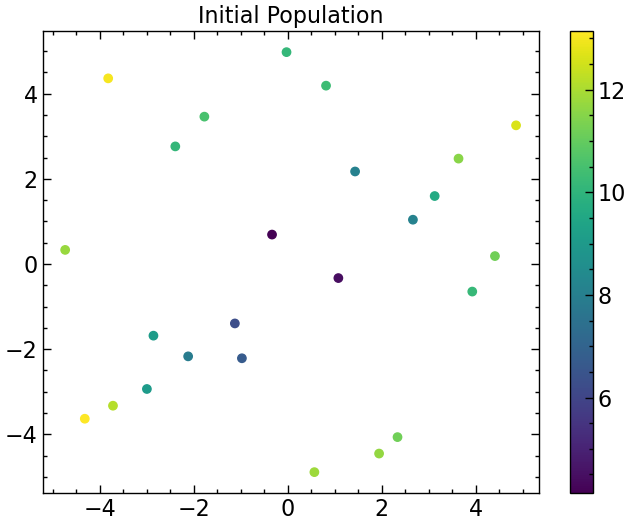

4.136302900065182
Generation 40: Best Fitness = 2.215384035452346
Best found solution =  4.136302900065182
4.136302900065182
Generation 40: Best Fitness = 0.775719888815836
Best found solution =  4.136302900065182
3.036134883117875
Generation 40: Best Fitness = 0.1102228830667587
Best found solution =  3.036134883117875
3.036134883117875
Generation 40: Best Fitness = 0.05140987330974167
Best found solution =  3.036134883117875
3.036134883117875
Generation 40: Best Fitness = 0.1853514399665888
Best found solution =  3.036134883117875
1.2051254980776567
Generation 40: Best Fitness = 2.8224231011513417
Best found solution =  1.2051254980776567
1.2051254980776567
Generation 40: Best Fitness = 1.2677363028184967
Best found solution =  1.2051254980776567
1.2051254980776567
Generation 40: Best Fitness = 1.0101195431963403
Best found solution =  1.2051254980776567
1.2051254980776567
Generation 40: Best Fitness = 1.0486569466564928
Best found solution =  1.2051254980776567
1.2051254980776567
Ge

KeyboardInterrupt: 

In [24]:
bounds = [(-5,5), (-5,5)] #bounds for each dimension (x and y)
bo = bayesianOptimiser(bounds, 25)

bo.runOptimiser()


In [4]:
import glob
import imageio
import os

image_files = sorted(glob.glob("BOEIPlots/*.png"), key=os.path.getmtime)
print(image_files)

images = [Image.open(img) for img in image_files]

# Step 3: Save images as a GIF
if images:
    # 'duration' is the time each frame stays on screen (milliseconds)
    images[0].save(
        "BOEIResult.gif",
        save_all=True,
        append_images=images[1:],  # Include the rest of the images
        duration=1000,               # Duration of each frame in milliseconds
        loop=0                       # 0 means loop indefinitely
    )

['BOEIPlots/0.png', 'BOEIPlots/1.png', 'BOEIPlots/2.png', 'BOEIPlots/3.png', 'BOEIPlots/4.png', 'BOEIPlots/5.png', 'BOEIPlots/6.png', 'BOEIPlots/7.png', 'BOEIPlots/8.png', 'BOEIPlots/9.png', 'BOEIPlots/10.png', 'BOEIPlots/11.png', 'BOEIPlots/12.png', 'BOEIPlots/13.png', 'BOEIPlots/14.png', 'BOEIPlots/15.png', 'BOEIPlots/16.png', 'BOEIPlots/17.png', 'BOEIPlots/18.png', 'BOEIPlots/19.png', 'BOEIPlots/20.png', 'BOEIPlots/21.png', 'BOEIPlots/22.png', 'BOEIPlots/23.png', 'BOEIPlots/24.png', 'BOEIPlots/25.png', 'BOEIPlots/26.png', 'BOEIPlots/27.png', 'BOEIPlots/28.png', 'BOEIPlots/29.png', 'BOEIPlots/30.png', 'BOEIPlots/31.png', 'BOEIPlots/32.png', 'BOEIPlots/33.png', 'BOEIPlots/34.png', 'BOEIPlots/35.png', 'BOEIPlots/36.png', 'BOEIPlots/37.png', 'BOEIPlots/38.png', 'BOEIPlots/39.png', 'BOEIPlots/40.png', 'BOEIPlots/41.png', 'BOEIPlots/42.png', 'BOEIPlots/43.png', 'BOEIPlots/44.png', 'BOEIPlots/45.png', 'BOEIPlots/46.png', 'BOEIPlots/47.png', 'BOEIPlots/48.png', 'BOEIPlots/49.png', 'BOEIPlot